# Project: Wrangling and Analyze Data

#### Import cecessary packages for the project

In [621]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import re

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Loading the downloaded WeRateDogs Twitter archive data csv file to a pandas datafrmae.

In [622]:
twitter_archive_df = pd.read_csv('twitter-archive-enhanced.csv')

2. Using the Requests library to download the tweet image prediction tsv file from the udacity server.

In [623]:
request_data = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
with open("image-predictions.tsv", 'w', encoding = request_data.encoding) as file:
    file.write(request_data.text)

ConnectionError: HTTPSConnectionPool(host='d17h27t6h515a5.cloudfront.net', port=443): Max retries exceeded with url: /topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002932E374910>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

In [625]:
image_predictions_df = pd.read_csv('image-predictions.tsv', sep='\t')

3. Using the Tweepy library to query additional data via the Twitter API.

import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = twitter_archive_df.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepyException as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

Defining a function that converts a json object to a dictionary for easy creation of dataframe.

In [626]:
def str_to_dict(text_file_line):
    '''convert text input to a json object and returns the required attributes'''
    
    attributes = ['id', 'retweet_count', 'favorite_count']#, 'retweeted']
    data = json.loads(line)
    attribute_dict = {x: data[x] for x in attributes}
    return attribute_dict

In [627]:
#Loading json data to a dataframe using a list of dictionaries.
with open('tweet-json.txt', 'r') as f:
    values = []
    raw_data = f.readlines()
    for line in raw_data:
        values.append(str_to_dict(line))

In [628]:
tweet_attributes_df = pd.DataFrame(values)

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



Creating copies of existing dataframes to be used in cleaning.

In [629]:
assess_twitter_archive_df = twitter_archive_df.copy(deep=True)
assess_image_predictions_df = image_predictions_df.copy(deep=True)
assess_tweet_attributes_df = tweet_attributes_df.copy(deep=True)

#### Visual assessment including done in external applications

In [630]:
assess_twitter_archive_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [631]:
assess_image_predictions_df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [632]:
assess_tweet_attributes_df

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


Where there are several occurances of a rating pattern, it appears some of the rating are incorrect

#### Assessing the data type for individual colmuns

In [633]:
assess_twitter_archive_df.dtypes

tweet_id                        int64
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                      object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator                int64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
dtype: object

In [634]:
assess_image_predictions_df.dtypes

tweet_id      int64
jpg_url      object
img_num       int64
p1           object
p1_conf     float64
p1_dog         bool
p2           object
p2_conf     float64
p2_dog         bool
p3           object
p3_conf     float64
p3_dog         bool
dtype: object

In [635]:
assess_tweet_attributes_df.dtypes

id                int64
retweet_count     int64
favorite_count    int64
dtype: object

- Inappropriate data type for timestamp (object)
- incorrect data type for id columns (int) since no calculation will be persomed on these columns.

#### checking for retweets using retweeted_status_id from the tweet archive data.

In [636]:
not_retweet = assess_twitter_archive_df.retweeted_status_id.isna()
retweet = assess_twitter_archive_df.retweeted_status_id.notnull()
retweet.any()

True

certain tweets have retweets ids effectively making them not poriginal tweets but rather retweets.

#### Checking to see if all tweets are dog rating using images.

In [637]:
# CHecking for images in which none of the 3 predictions are dogs.
assess_image_predictions_df.query('~p1_dog & ~p2_dog & ~p3_dog')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,0.015250,False,great_grey_owl,0.013207,False
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,0.002402,False,hamster,0.000461,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2021,880935762899988482,https://pbs.twimg.com/media/DDm2Z5aXUAEDS2u.jpg,1,street_sign,0.251801,False,umbrella,0.115123,False,traffic_light,0.069534,False
2022,881268444196462592,https://pbs.twimg.com/media/DDrk-f9WAAI-WQv.jpg,1,tusker,0.473303,False,Indian_elephant,0.245646,False,ibex,0.055661,False
2046,886680336477933568,https://pbs.twimg.com/media/DE4fEDzWAAAyHMM.jpg,1,convertible,0.738995,False,sports_car,0.139952,False,car_wheel,0.044173,False
2052,887517139158093824,https://pbs.twimg.com/ext_tw_video_thumb/88751...,1,limousine,0.130432,False,tow_truck,0.029175,False,shopping_cart,0.026321,False


Some of the tweets evaluated false for all images, that is none of the images contained dogs and thus are not dog ratings.

#### Checking to see if all tweets have images, i.e checking if all tweets from the tweet archive data have corrosponding image data in image_predictions

In [638]:
assess_twitter_archive_df.tweet_id.isin(assess_image_predictions_df.tweet_id).all()

False

Not all tweet's from the tweet_archive data have images.

#### Checking whether all tweet's have the favourite_count and retweet_count attributes.

In [639]:
assess_twitter_archive_df.tweet_id.isin(assess_tweet_attributes_df.id).all()

False

Not all tweets have favourite_count and retweet_count attributes.

#### writing a function that identifies occurances of multiple rating 'format' in text.

In [640]:
def check_ratings(text):
    """returns number of 'format' occurances"""
    regex = "(\d+/\d+)"
    matches = re.finditer(regex, text)
    return len(list(matches))

In [641]:
assess_twitter_archive_df['rating_format_occurances'] = assess_twitter_archive_df.text.apply(check_ratings)

In [642]:
assess_twitter_archive_df.query('rating_format_occurances > 1')[['tweet_id','text','rating_numerator', 'rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
55,881633300179243008,@roushfenway These are good dogs but 17/10 is ...,17,10
313,835246439529840640,@jonnysun @Lin_Manuel ok jomny I know you're e...,960,0
561,802624713319034886,"RT @dog_rates: ""Yep... just as I suspected. Yo...",12,10
766,777684233540206592,"""Yep... just as I suspected. You're not flossi...",12,10
784,775096608509886464,"RT @dog_rates: After so many requests, this is...",9,11
860,763167063695355904,RT @dog_rates: Meet Eve. She's a raging alcoho...,8,10
1007,747600769478692864,This is Bookstore and Seaweed. Bookstore is ti...,10,10
1068,740373189193256964,"After so many requests, this is Bretagne. She ...",9,11
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https...,4,20
1202,716439118184652801,This is Bluebert. He just saw that both #Final...,50,50


There are occurances where the rating is incorrect

In [643]:
assess_twitter_archive_df.in_reply_to_status_id.shape

(2356,)

In [644]:
assess_twitter_archive_df.duplicated().any()

False

In [645]:
assess_image_predictions_df.duplicated().any()

False

In [646]:
assess_tweet_attributes_df.duplicated().any()

False

### Quality issues

#### twitter_archive_df

1. Not all tweets are original tweets.

2. Not all tweets have images.

3. Not all tweets are dogs ratings, e.g ratings hor human, sharks, lobsters etc. 

4. Not all tweets have all the required attributes, retweet_count and favourite_count.

5. Inappropriate data type for time stamp.

6. id column data type incorrect.

7. Dog stage names contain "None" value.

8. incorrect ratings.

#### image_predictions_df

10. Not all all images contain dogs.

### Tidiness issues
1. Column headers are values, not variable names. The dog stage names are values.

2. Retweet_count and favourite_count are tweet attributes represented by a seperate dataframe from the tweet_archive_df.

3. The images in image_predictions are part of the tweet data not seperate observations.

3. Some tweets contain ratings for more than one dog.

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

#### Cleaning Tydness Issues

In [647]:
# Copying original data
cleaned_twitter_archive_df = twitter_archive_df.copy(deep=True)
cleaned_image_predictions_df = image_predictions_df.copy(deep=True)
cleaned_tweet_attributes_df = tweet_attributes_df.copy(deep=True)

### Issue #1: retweet_count and favourite_count are tweet attributes represented by a seperate dataframe from the tweet_archive_df.
### Issue #4: Not all tweets have all the required attribues, retweet_count and favourite_count.

#### Define: data about a single type of observation is spread accross multiple tables. We use pd.concat to merge tweet data and its attributes. We are going to drop row which does not have correspong values in secong table. [ How to merge pandas df ]( https://www.shanelynn.ie/merge-join-dataframes-python-pandas-index-1/#:~:text=Different%20column%20names%20are%20specified,to%20the%20pandas%20merge%20function. )

#### We will use an "inner" merge to effectively discard tweets without the retweet_count and favouritte_count values.

#### Code

In [648]:
cleaned_twitter_archive_df.shape

(2356, 17)

In [649]:
cleaned_twitter_archive_df = pd.merge(cleaned_twitter_archive_df, cleaned_tweet_attributes_df, left_on = 'tweet_id', right_on = 'id', how='inner')
cleaned_twitter_archive_df.drop('id', axis=1, inplace=True)

#### Test

In [650]:
cleaned_twitter_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2354 entries, 0 to 2353
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2354 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2354 non-null   object 
 4   source                      2354 non-null   object 
 5   text                        2354 non-null   object 
 6   retweeted_status_id         179 non-null    float64
 7   retweeted_status_user_id    179 non-null    float64
 8   retweeted_status_timestamp  179 non-null    object 
 9   expanded_urls               2295 non-null   object 
 10  rating_numerator            2354 non-null   int64  
 11  rating_denominator          2354 non-null   int64  
 12  name                        2354 non-null   object 
 13  doggo                       2354 

### Issue #7: Dog stage names contain "None" value.

#### Define: The pandas default value for "None" is np.NaN, we will use the replace method to fix the values.

#### Code

In [651]:
# replace "None"with np.nan accross all columns.
cleaned_twitter_archive_df.replace("None", np.nan, inplace=True)

#### Test

In [652]:
cleaned_twitter_archive_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,NaN,NaN,NaN,8853,39467
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,NaN,NaN,NaN,6514,33819
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,NaN,NaN,NaN,4328,25461
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,NaN,NaN,NaN,8964,42908
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,NaN,NaN,NaN,9774,41048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,NaN,NaN,NaN,NaN,NaN,41,111
2350,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,NaN,NaN,NaN,NaN,147,311
2351,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,NaN,NaN,NaN,NaN,47,128
2352,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,NaN,NaN,NaN,NaN,48,132


### Issue #2: Column headers are values, not variable names.

#### Define: The dog stage columns are identifier variables, and we can use the pd.melt function to correct this and set the column values to measured variables.

#### Code

In [653]:
columns = cleaned_twitter_archive_df.columns.drop(labels = ['doggo', 'floofer', 'pupper', 'puppo'])
cleaned_twitter_archive_df = pd.melt(cleaned_twitter_archive_df, id_vars = columns, value_vars=['doggo', 'floofer', 'pupper', 'puppo'], var_name='dog_stage', value_name='dog_stage_value')

Drop all rows with Nulls, these are duplicate rows, the appripriate rows have been captured with the appropriate dog type.

In [654]:
cleaned_twitter_archive_df.dropna(subset=['dog_stage_value'], inplace=True)

Values in variable: dog_stage and value: dog_stage_value are now similar, we can drop one of the column-dog_stage_value

In [655]:
cleaned_twitter_archive_df.drop('dog_stage_value', axis=1, inplace=True)

#### Test

In [656]:
cleaned_twitter_archive_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,dog_stage
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,7711,32467,doggo
42,884162670584377345,NaN,NaN,2017-07-09 21:29:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Yogi. He doesn't have any important dog m...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/884162670...,12,10,Yogi,3128,20771,doggo
98,872967104147763200,NaN,NaN,2017-06-09 00:02:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a very large dog. He has a date later. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/872967104...,12,10,NaN,5669,28031,doggo
107,871515927908634625,NaN,NaN,2017-06-04 23:56:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Napolean. He's a Raggedy East Nicaragu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/871515927...,12,10,Napolean,3628,20730,doggo
109,871102520638267392,NaN,NaN,2017-06-03 20:33:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Never doubt a doggo 14/10 https://t.co/AbBLh2FZCH,NaN,NaN,NaN,https://twitter.com/animalcog/status/871075758...,14,10,NaN,5764,21461,doggo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8007,752519690950500352,NaN,NaN,2016-07-11 15:07:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Hopefully this puppo on a swing will help get ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/752519690...,11,10,NaN,3917,8157,puppo
8021,751132876104687617,NaN,NaN,2016-07-07 19:16:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cooper. He's just so damn happy. 10/10...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/751132876...,10,10,Cooper,1480,5610,puppo
8095,744995568523612160,NaN,NaN,2016-06-20 20:49:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Abby. She got her face stuck in a glas...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/744995568...,9,10,Abby,716,3277,puppo
8108,743253157753532416,NaN,NaN,2016-06-16 01:25:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Kilo. He cannot reach the snackum. Nif...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/743253157...,10,10,Kilo,1366,4624,puppo


#### Quality Issues

### Issue #5: Inappropriate data type for time stamp.
### Issue #6:  Inappropriate data type for id columns.

#### Define: timestamp set as 'object' data type is a datetime object. 

#### Id's should be set as object not integer since we wont be using this columns in any calculation. We can use the pd.astype method to set the appropriate data type. [ pandas astype method]( https://stackoverflow.com/questions/17134716/convert-dataframe-column-type-from-string-to-datetime )

#### Code

In [657]:
cleaned_twitter_archive_df['timestamp'] = pd.to_datetime(cleaned_twitter_archive_df.timestamp)
cleaned_twitter_archive_df['tweet_id'] = cleaned_twitter_archive_df.tweet_id.astype(str)
cleaned_image_predictions_df['tweet_id'] = cleaned_image_predictions_df.tweet_id.astype(str)

#### Test

In [658]:
cleaned_twitter_archive_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,dog_stage
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,7711,32467,doggo
42,884162670584377345,NaN,NaN,2017-07-09 21:29:42+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Yogi. He doesn't have any important dog m...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/884162670...,12,10,Yogi,3128,20771,doggo
98,872967104147763200,NaN,NaN,2017-06-09 00:02:31+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a very large dog. He has a date later. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/872967104...,12,10,NaN,5669,28031,doggo
107,871515927908634625,NaN,NaN,2017-06-04 23:56:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Napolean. He's a Raggedy East Nicaragu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/871515927...,12,10,Napolean,3628,20730,doggo
109,871102520638267392,NaN,NaN,2017-06-03 20:33:19+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Never doubt a doggo 14/10 https://t.co/AbBLh2FZCH,NaN,NaN,NaN,https://twitter.com/animalcog/status/871075758...,14,10,NaN,5764,21461,doggo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8007,752519690950500352,NaN,NaN,2016-07-11 15:07:30+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Hopefully this puppo on a swing will help get ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/752519690...,11,10,NaN,3917,8157,puppo
8021,751132876104687617,NaN,NaN,2016-07-07 19:16:47+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Cooper. He's just so damn happy. 10/10...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/751132876...,10,10,Cooper,1480,5610,puppo
8095,744995568523612160,NaN,NaN,2016-06-20 20:49:19+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Abby. She got her face stuck in a glas...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/744995568...,9,10,Abby,716,3277,puppo
8108,743253157753532416,NaN,NaN,2016-06-16 01:25:36+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Kilo. He cannot reach the snackum. Nif...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/743253157...,10,10,Kilo,1366,4624,puppo


In [659]:
cleaned_image_predictions_df.dtypes

tweet_id     object
jpg_url      object
img_num       int64
p1           object
p1_conf     float64
p1_dog         bool
p2           object
p2_conf     float64
p2_dog         bool
p3           object
p3_conf     float64
p3_dog         bool
dtype: object

### Issue #8: Incorrect Ratings.

#### Define: Some tweets contain more than 1 occurance of text in the fomart of a rating. From visual inspection we find there are 3 cases:
##### Data to be kept:
- There is some text e.g 9/11 survivour and 7/11 store; before the actual rating. In this case we will mannually input the proper rating.

##### Data to be deleted:
- There are more than one dog referenced in the tweet. These tweets will be dropped as we can not be certain about the dog breed from the prediction.
- There are retweets, where people posted a second suggested rating. Retweets will be deleted.

#### Code

In [660]:
# Check for row simingly with the identified characteristic
cleaned_twitter_archive_df['rating_format_occurances'] = cleaned_twitter_archive_df.text.apply(check_ratings)

In [661]:
# quantify incorrect ratings
num_b4_clean = cleaned_twitter_archive_df.query('rating_format_occurances > 1')[['tweet_id','text','rating_numerator', 'rating_denominator']].shape

In [662]:
# drop tweets with more than 1 dog, tweets including rating for other mamals e.g cats, human
tweet_ids = ['802624713319034000', '777684233540206000', '747600769478692000', '714258258790387000', '703356393781329000', '694352839993344000', '691483041324204000', '689835978131935000', '677314812125323000', '676191832485810000', '674737130913071000', '674646392044941000', '671154572044468000', '670434127938719000', '669037058363662000', '667491009379606000', '666835007768551000', '881633300179243000', '835246439529840000', '763167063695355000', '722974582966214000', '695064344191721000', '672248013293752000', '668537837512433000'
            ]
#cleaned_twitter_archive_df.drop(cleaned_twitter_archive_df[cleaned_twitter_archive_df['status_id' in tweet_ids])
idx = cleaned_twitter_archive_df.query('tweet_id in @tweet_ids').index
if len(idx):
    cleaned_twitter_archive_df.drop(idx, inplace = True)
    
print(f'index for deletion {idx.values}')

index for deletion []


In [663]:
def second_ratings(text):
    """returns the second occurance of rating"""
    regex = "(\d+/\d+)"
    matches = re.findall(regex, text)
    return matches[1].split('/')

In [664]:
# change ratings
tweet_ids = ['775096608509886000','740373189193256000','716439118184652000','682962037429899000','666287406224695000']
idx = cleaned_twitter_archive_df.query('tweet_id in @tweet_ids').index

if len(idx):
    for i in idx:
        cleaned_twitter_archive_df.iloc[i, 10], cleaned_twitter_archive_df.iloc[i, 11]  = second_ratings(cleaned_twitter_archive_df.iloc[i, 5])  

#### Test

In [665]:
num_aft_clean = cleaned_twitter_archive_df.query('rating_format_occurances > 1')[['tweet_id','text','rating_numerator', 'rating_denominator']].shape

In [666]:
f'shape before cleaning: {num_b4_clean} \
shape after cleaning: {num_aft_clean}'

'shape before cleaning: (3, 4) shape after cleaning: (3, 4)'

In [667]:
cleaned_twitter_archive_df.drop('rating_format_occurances', axis=1, inplace=True)

### Issue #1: Not all tweets are original tweets.

#### Define: We require only original tweets for our analysis. We can use the retweeted_status_id column to identify retweets.

#### Code

In [668]:
# checking for retweets
cleaned_twitter_archive_df[~cleaned_twitter_archive_df['retweeted_status_id'].isna()].shape

(37, 16)

In [669]:
# discarding all tweets with a retweeted_status_id
cleaned_twitter_archive_df = cleaned_twitter_archive_df[cleaned_twitter_archive_df['retweeted_status_id'].isna()]

#### Test

In [670]:
# checking for retweets
cleaned_twitter_archive_df[~cleaned_twitter_archive_df['retweeted_status_id'].isna()].shape

(0, 16)

In [671]:
cleaned_twitter_archive_df.shape

(356, 16)

#### Delete columns of no relavance to the analysis. The retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp and columns are all nulls and should be dropped freom the DataFrame.

In [672]:
cleaned_twitter_archive_df.retweeted_status_id.unique()

array([nan])

In [673]:
# removing identified columns
cleaned_twitter_archive_df.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)

C:\Users\Charles\AppData\Local\Temp\ipykernel_3808\756092290.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_twitter_archive_df.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)


In [674]:
# check for removed columns
cleaned_twitter_archive_df.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'retweet_count', 'favorite_count',
       'dog_stage'],
      dtype='object')

### Issue #3: Not all tweets are dogs ratings.

#### Define: Not all images contain dogs, we can validate this by checking the highest prediction confidence, p1_dog corresponds to a dog

#### Code

In [675]:
cleaned_image_predictions_df.shape

(2075, 12)

In [676]:
# take only row where p1_dog validates to True.
cleaned_image_predictions_df = cleaned_image_predictions_df.query('p1_dog  == True')

#### Test

In [677]:
cleaned_image_predictions_df.p1_dog.unique()

array([ True])

### Issue #2: Not all tweets have images.

#### Define: Not all tweet_ids from the cleaned_twitter_archive_df have coresponding tweet_id in the image_prediction_df. We will use the DataFrame.isin method to identify common tweet_id.

#### Code

In [678]:
# check if any tweets without images, False indicates tweet with "images not found" status
cleaned_twitter_archive_df.tweet_id.isin(cleaned_image_predictions_df.tweet_id).all()

False

In [679]:
images_tweet_id = cleaned_image_predictions_df.tweet_id

In [680]:
cleaned_twitter_archive_df = cleaned_twitter_archive_df.query("tweet_id in @images_tweet_id")

#### Test

In [681]:
# check if any tweets without images, False indicates tweet with "images not found" status
cleaned_twitter_archive_df.tweet_id.isin(cleaned_image_predictions_df.tweet_id).all()

True

In [682]:
cleaned_twitter_archive_df.shape

(238, 13)

#### Test

In [683]:
cleaned_twitter_archive_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,dog_stage
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,7711,32467,doggo
42,884162670584377345,NaN,NaN,2017-07-09 21:29:42+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Yogi. He doesn't have any important dog m...,https://twitter.com/dog_rates/status/884162670...,12,10,Yogi,3128,20771,doggo
98,872967104147763200,NaN,NaN,2017-06-09 00:02:31+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a very large dog. He has a date later. ...,https://twitter.com/dog_rates/status/872967104...,12,10,NaN,5669,28031,doggo
107,871515927908634625,NaN,NaN,2017-06-04 23:56:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Napolean. He's a Raggedy East Nicaragu...,https://twitter.com/dog_rates/status/871515927...,12,10,Napolean,3628,20730,doggo
120,869596645499047938,NaN,NaN,2017-05-30 16:49:31+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Scout. He just graduated. Officially a...,https://twitter.com/dog_rates/status/869596645...,12,10,Scout,3327,16476,doggo
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7982,756275833623502848,NaN,NaN,2016-07-21 23:53:04+00:00,"<a href=""http://twitter.com/download/iphone"" r...",When ur older siblings get to play in the deep...,https://twitter.com/dog_rates/status/756275833...,10,10,NaN,1738,7114,puppo
8021,751132876104687617,NaN,NaN,2016-07-07 19:16:47+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Cooper. He's just so damn happy. 10/10...,https://twitter.com/dog_rates/status/751132876...,10,10,Cooper,1480,5610,puppo
8095,744995568523612160,NaN,NaN,2016-06-20 20:49:19+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Abby. She got her face stuck in a glas...,https://twitter.com/dog_rates/status/744995568...,9,10,Abby,716,3277,puppo
8108,743253157753532416,NaN,NaN,2016-06-16 01:25:36+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Kilo. He cannot reach the snackum. Nif...,https://twitter.com/dog_rates/status/743253157...,10,10,Kilo,1366,4624,puppo


### Tidyness Issue #3: The images in image_predictions are part of the tweet data not seperate observations.

#### Define: We need to merge image_predictions to the tweet_data to confirm to tidy data principle. We will use the merge junction to accomplish this.

In [684]:
#We will only merge with the p1 column, since it is the only column our analysis will be carried out on.
cleaned_twitter_archive_df = pd.merge(cleaned_twitter_archive_df, cleaned_image_predictions_df[['tweet_id', 'p1']], left_on = 'tweet_id', right_on = 'tweet_id', how='inner')
cleaned_twitter_archive_df.drop('tweet_id', axis=1, inplace=True)

In [685]:
cleaned_twitter_archive_df.rename(columns={'p1' : 'breed'}, inplace=True)

In [686]:
cleaned_twitter_archive_df

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,dog_stage,breed
0,NaN,NaN,2017-07-26 15:59:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,7711,32467,doggo,Pembroke
1,NaN,NaN,2017-07-09 21:29:42+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Yogi. He doesn't have any important dog m...,https://twitter.com/dog_rates/status/884162670...,12,10,Yogi,3128,20771,doggo,German_shepherd
2,NaN,NaN,2017-06-09 00:02:31+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a very large dog. He has a date later. ...,https://twitter.com/dog_rates/status/872967104...,12,10,NaN,5669,28031,doggo,Labrador_retriever
3,NaN,NaN,2017-06-04 23:56:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Napolean. He's a Raggedy East Nicaragu...,https://twitter.com/dog_rates/status/871515927...,12,10,Napolean,3628,20730,doggo,komondor
4,NaN,NaN,2017-05-30 16:49:31+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Scout. He just graduated. Officially a...,https://twitter.com/dog_rates/status/869596645...,12,10,Scout,3327,16476,doggo,Chihuahua
...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,NaN,NaN,2016-07-21 23:53:04+00:00,"<a href=""http://twitter.com/download/iphone"" r...",When ur older siblings get to play in the deep...,https://twitter.com/dog_rates/status/756275833...,10,10,NaN,1738,7114,puppo,Airedale
234,NaN,NaN,2016-07-07 19:16:47+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Cooper. He's just so damn happy. 10/10...,https://twitter.com/dog_rates/status/751132876...,10,10,Cooper,1480,5610,puppo,Labrador_retriever
235,NaN,NaN,2016-06-20 20:49:19+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Abby. She got her face stuck in a glas...,https://twitter.com/dog_rates/status/744995568...,9,10,Abby,716,3277,puppo,Old_English_sheepdog
236,NaN,NaN,2016-06-16 01:25:36+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Kilo. He cannot reach the snackum. Nif...,https://twitter.com/dog_rates/status/743253157...,10,10,Kilo,1366,4624,puppo,malamute


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [687]:
cleaned_twitter_archive_df.to_csv("twitter_archive_master.csv")

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

#### Summary statistics

In [688]:
cleaned_twitter_archive_df.describe()

,in_reply_to_status_id,in_reply_to_user_id,rating_numerator,rating_denominator,retweet_count,favorite_count
count,2.000000e+00,2.000000e+00,238.000000,238.0,238.000000,238.000000
mean,7.331095e+17,4.196984e+09,11.378151,10.0,4225.470588,12605.584034
std,0.000000e+00,0.000000e+00,1.839517,0.0,8303.030105,18259.112194
min,7.331095e+17,4.196984e+09,5.000000,10.0,103.000000,693.000000
25%,7.331095e+17,4.196984e+09,10.000000,10.0,998.500000,2928.000000
50%,7.331095e+17,4.196984e+09,11.500000,10.0,1880.500000,6620.000000
75%,7.331095e+17,4.196984e+09,12.000000,10.0,3652.000000,13667.250000
max,7.331095e+17,4.196984e+09,27.000000,10.0,79515.000000,132810.000000


Add a calculated field represanting the rating.

In [689]:
cleaned_twitter_archive_df['rating'] = cleaned_twitter_archive_df['rating_numerator']/cleaned_twitter_archive_df['rating_denominator']

#### Checking for correlation between numeric variables.

In [690]:
#Check for correlations between individual variables
correlations = cleaned_twitter_archive_df[['rating_numerator', 'rating_denominator', 'retweet_count', 'favorite_count', 'rating']].corr(numeric_only=True)
correlations = correlations.unstack()
correlations_sorted = correlations.sort_values(kind='quicksort', ascending=False)
correlations_sorted

rating_numerator    rating_numerator      1.000000
retweet_count       retweet_count         1.000000
favorite_count      favorite_count        1.000000
rating              rating                1.000000
rating_numerator    rating                1.000000
rating              rating_numerator      1.000000
retweet_count       favorite_count        0.931329
favorite_count      retweet_count         0.931329
rating_numerator    favorite_count        0.361565
favorite_count      rating_numerator      0.361565
                    rating                0.361565
rating              favorite_count        0.361565
rating_numerator    retweet_count         0.286824
retweet_count       rating_numerator      0.286824
                    rating                0.286824
rating              retweet_count         0.286824
rating_numerator    rating_denominator         NaN
rating_denominator  rating_numerator           NaN
                    rating_denominator         NaN
                    retweet_cou

The results from the cell above reviews every column is paired against its self, and there is also a triangular pairing of columns. These pairings will need to be dropped. Taken from: [ Throw out the correlation matrix and use bar charts to visualize correlation ]( https://typefully.com/levikul09/j6qzwR0 )

In [691]:
def get_reduntant_pairs(dataframe):
    pairs_to_drop = set()
    columns = dataframe.columns
    num_columns = dataframe.shape[1]
    for i in range(0, num_columns):
        for j in range(0, i+1):
            pairs_to_drop.add((columns[i], columns[j]))
    return pairs_to_drop 

In [692]:
# since correlation is calculated on numeric columns only, we check for redundancy on these.
numeric_columns = [
'rating_numerator', 'rating_denominator', 'retweet_count', 'favorite_count'
]
labels_to_drop = get_reduntant_pairs(cleaned_twitter_archive_df[numeric_columns])
correlations_sorted.drop(labels=labels_to_drop, inplace=True)

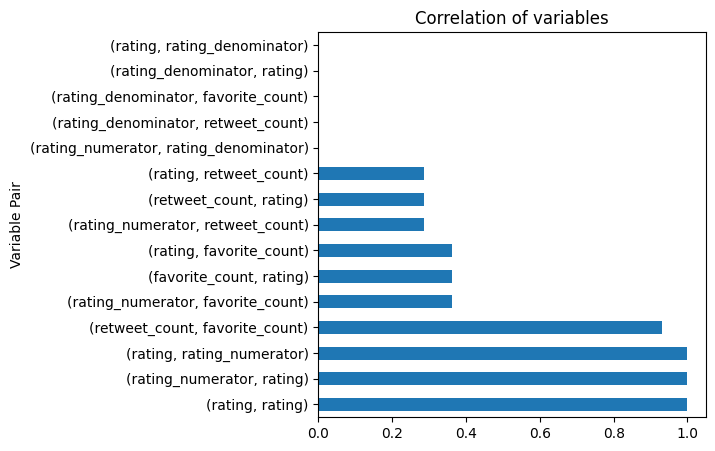

In [693]:
plt.figure()
plt.title('Correlation of variables')
plt.ylabel('Variable Pair')
correlations_sorted.plot.barh(figsize=(5, 5));

There is a high correlation between retweet_count and favourite_count.

Checking the average rating for a dog breed. 

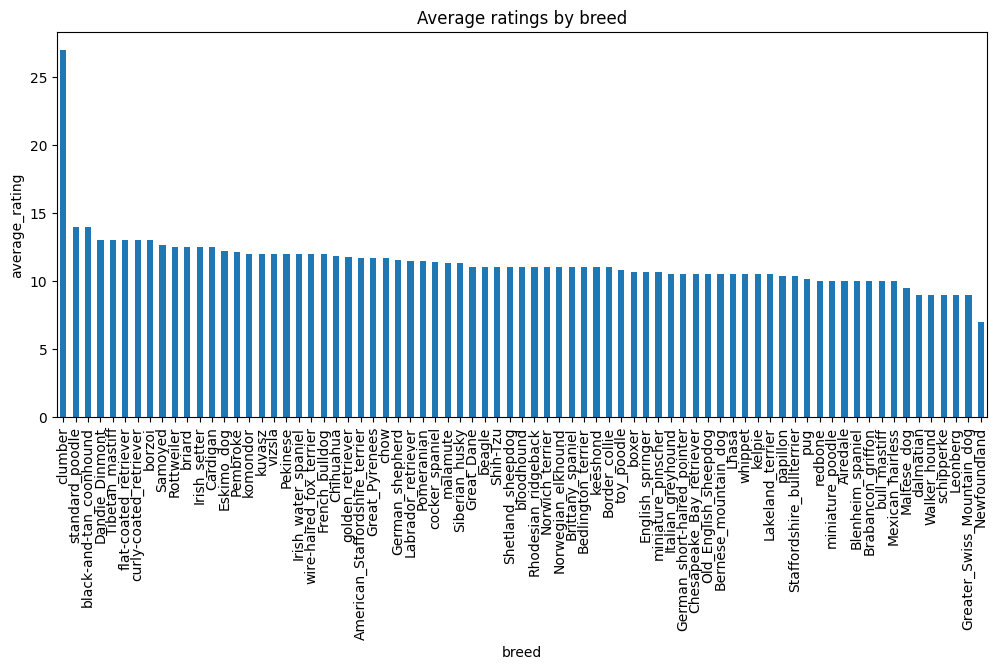

In [694]:
cleaned_twitter_archive_df.groupby('breed')['rating_numerator'].mean(numeric_only=True).sort_values(ascending=False).plot(kind='bar',  title='Average ratings by breed', xlabel='breed', ylabel='average_rating', figsize= (12,5));

On average, the clumber breed received the highest rating_numerator, with the newfoundland receiving the least rating_numerator.

Check to see if outliers and maximum breed rating greatly affects the average.  

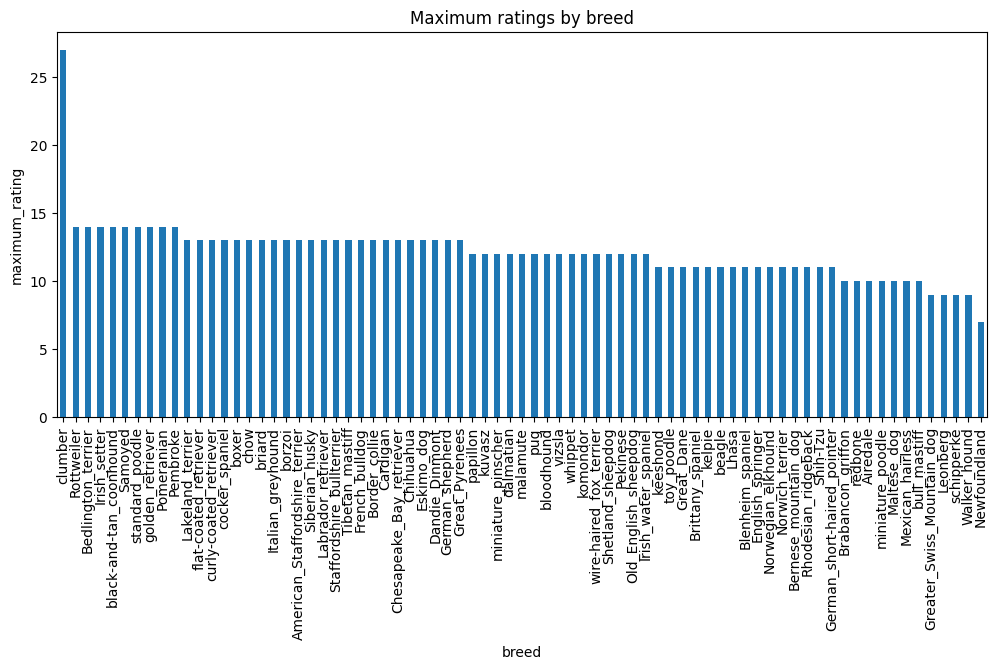

In [695]:
cleaned_twitter_archive_df.groupby('breed')['rating_numerator'].max(numeric_only=True).sort_values(ascending=False).plot(kind='bar',  title='Maximum ratings by breed', xlabel='breed', ylabel='maximum_rating', figsize= (12,5));

It appears the ratings are not greatly affected by the maximum.

We further investigate if higher ratings are associated with breed or dog stage.

In [696]:
# check ratings per breed per dog stage
ratings_sorted = cleaned_twitter_archive_df.groupby(['dog_stage', 'breed'])['rating'].max().sort_values(ascending=False)[:10]

In [697]:
ratings_sorted[ : 10]

dog_stage  breed                  
pupper     clumber                    2.7
doggo      Bedlington_terrier         1.4
           standard_poodle            1.4
pupper     Pomeranian                 1.4
           golden_retriever           1.4
           Samoyed                    1.4
puppo      Rottweiler                 1.4
pupper     black-and-tan_coonhound    1.4
doggo      Pembroke                   1.4
           Irish_setter               1.4
Name: rating, dtype: float64

There is no obvious relationship between ratings, breed and dog stage.

Checking propotions for retweet_count of each dog stage.

In [698]:
dog_stage_fav_count = cleaned_twitter_archive_df.groupby('dog_stage')['favorite_count'].sum()/cleaned_twitter_archive_df['favorite_count'].sum()
dog_stage_retweet_count = cleaned_twitter_archive_df.groupby('dog_stage')['retweet_count'].sum()/cleaned_twitter_archive_df['retweet_count'].sum()

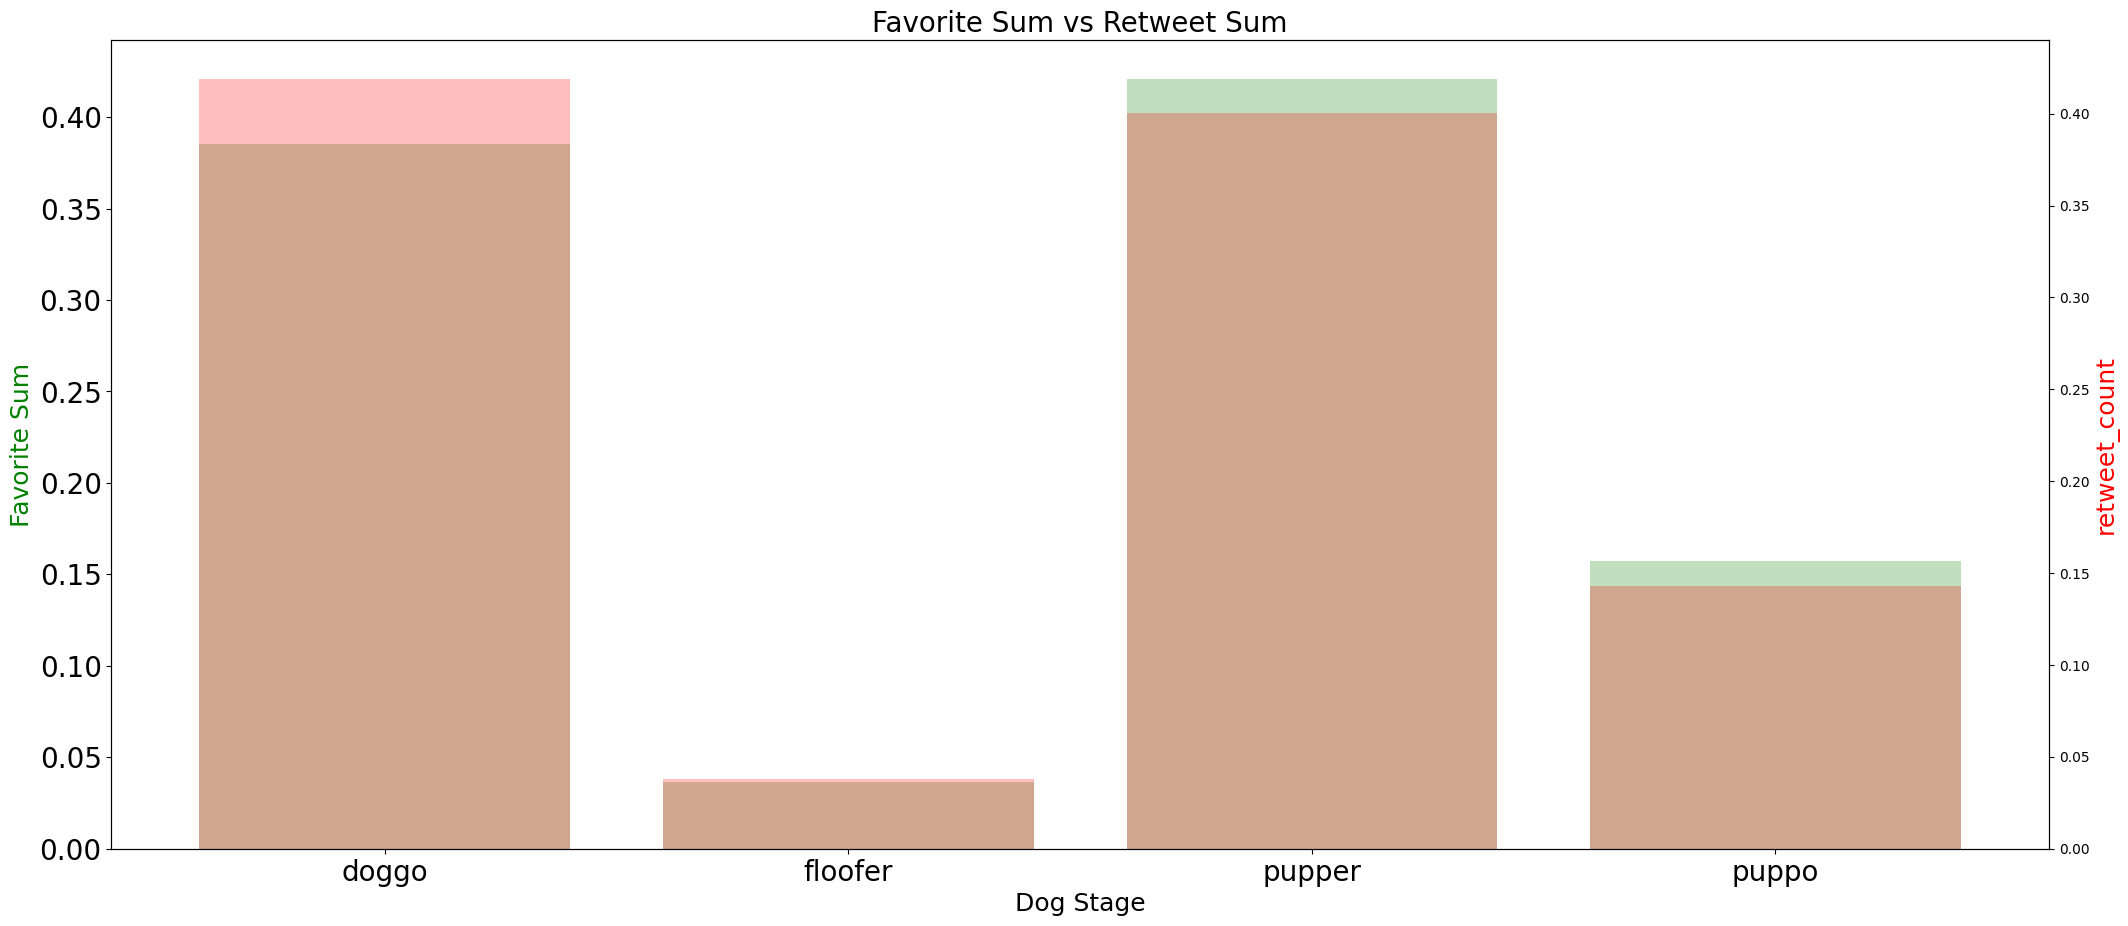

In [699]:
fig,ax = plt.subplots()
fig.set_size_inches(25, 10.5)
ax.set_title('Favorite Sum vs Retweet Sum', fontsize=20)
ax.bar(dog_stage_fav_count.index, dog_stage_fav_count.values, color='g', alpha=0.25)
ax.set_ylabel("Favorite Sum", color="g", fontsize=18)
ax.set_xlabel("Dog Stage", fontsize=18)
ax2=ax.twinx()
ax2.bar(dog_stage_retweet_count.index, dog_stage_retweet_count.values, color='r', alpha=0.25)
ax2.set_ylabel("retweet_count", color="r", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=20);

In [700]:
fig.savefig('Favourite_Sum_vs_Retweet_Sum_proportion')

- It appears each dog stage is likely to get a proportion of the retweets as it did that of the faourites. 
- The footer had the least proportion, followed by the puppo.

In [701]:
# assessing represantion in the dog_stage column
data = cleaned_twitter_archive_df['dog_stage'].value_counts()

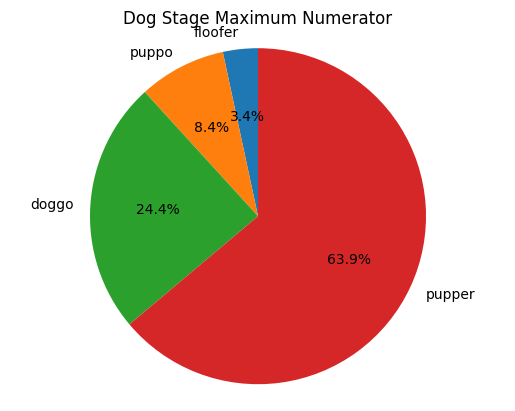

In [702]:
data = data.sort_values()
values = data.values
label = data.index
 
plt.pie(values, labels=label, autopct='%1.1f%%', startangle=90)
plt.title('Dog Stage Maximum Numerator')
plt.axis('equal')
plt.savefig('dog_Stage_Maximu_Numerator.png')
plt.show()

It appears in this dataset there were more submissions for pupper than any other category. This is likely the cause for the ranking above, pupper has the most retweets and favourites because it is the most represented category in the data set.

### Insights:
1. Pupper has the most retweets and favourites. This is because this is the most represented category in the dataset.

2. There is a high correlation between retweet_count and favourite_count. On average, a tweet receives a similar proportion of retweets as it does favourites.

3. The clumber breed has the highest mean rating_numerator, and also the highest maximum rating_numerator for a breed. How ever there doesn't seem to be much of a correlation between the maximum and the average rating_numerator.

### Visualization

Visualizing the relationship between the mean rating_numerator and max rating_numerator per dog breed.

In [703]:
breed_rating_max = cleaned_twitter_archive_df.groupby('breed')['rating_numerator'].max(numeric_only=True)
breed_rating_mean = cleaned_twitter_archive_df.groupby('breed')['rating_numerator'].mean(numeric_only=True)

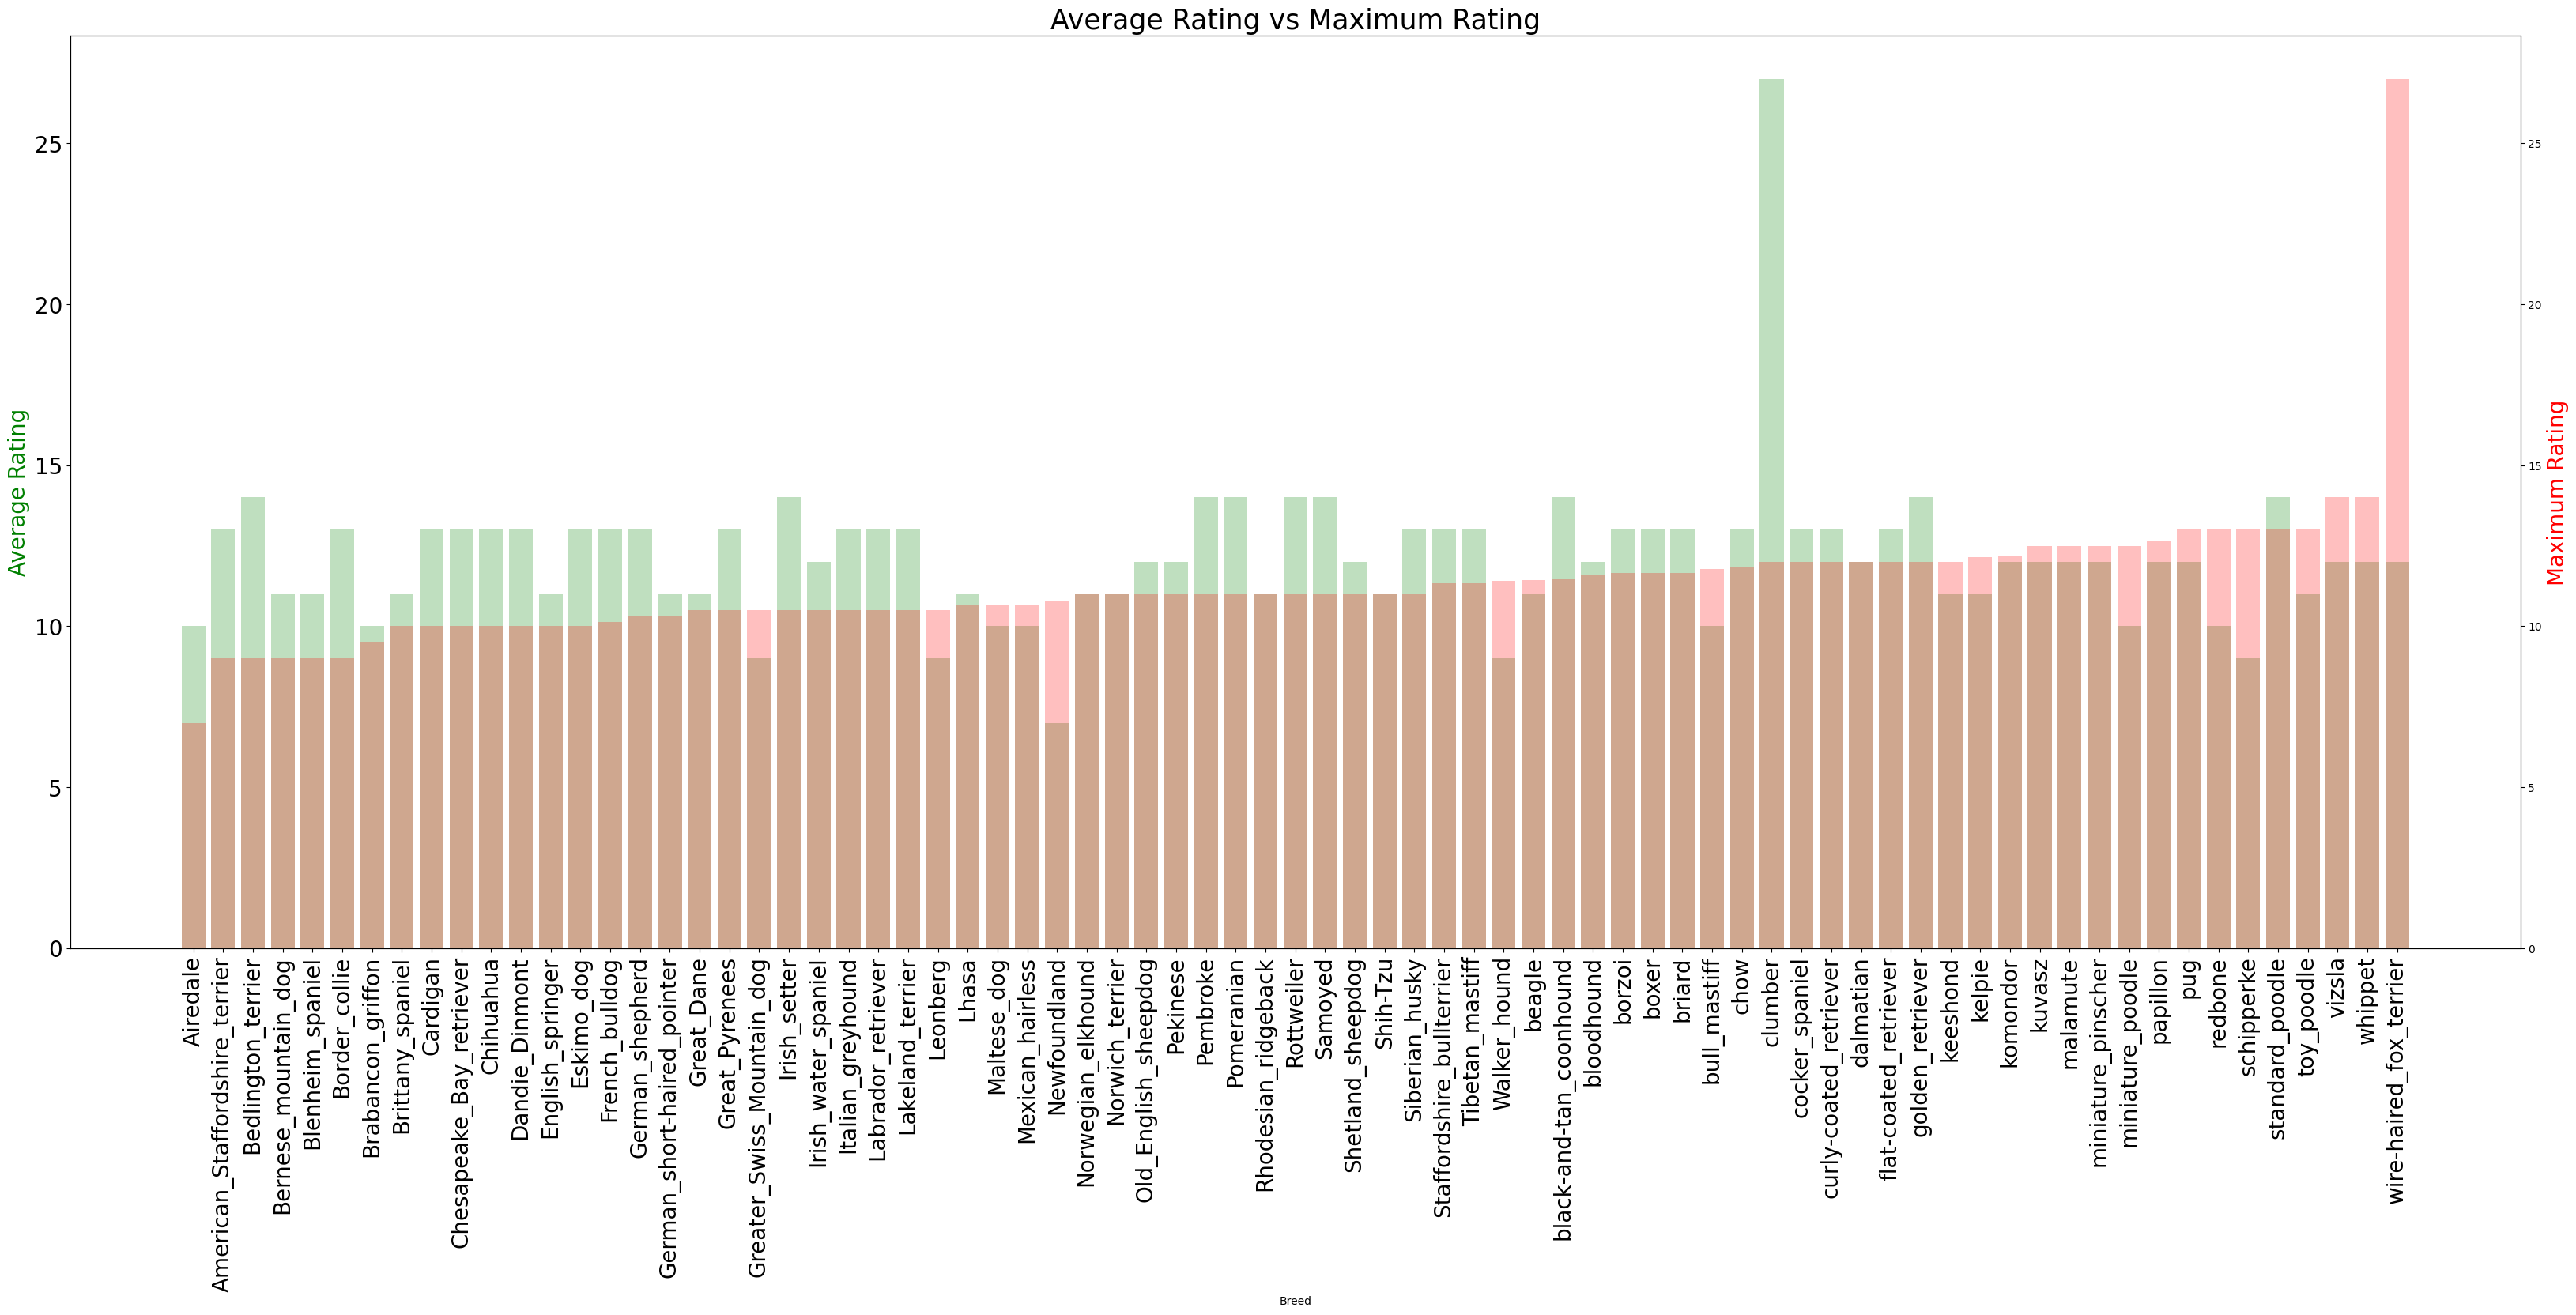

In [704]:
fig,ax = plt.subplots()
fig.set_size_inches(40, 15)
ax.set_title('Average Rating vs Maximum Rating', fontsize=25)
ax.bar(breed_rating_max.index, breed_rating_max.values, color='g', alpha=0.25)
ax.set_ylabel("Average Rating", color="g", fontsize=20)
ax.set_xlabel("Breed")
ax2=ax.twinx()
ax2.bar(breed_rating_mean.index, sorted(breed_rating_mean.values), color='r', alpha=0.25)
ax2.set_ylabel("Maximum Rating", color="r", fontsize=20)
ax.xaxis.set_tick_params(rotation=90)
ax2.xaxis.set_tick_params(rotation=90)
ax.tick_params(axis='both', which='major', labelsize=20)

In [705]:
fig.savefig('average_rating_vs_maximum')